In [1]:
import sys
import os

sys.path.append("../../")
sys.path.append("../../outboxml")

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)


from statistics import LinearRegression

import pandas as pd
import numpy as np

from outboxml.automl_manager import AutoMLManager
from outboxml.core.email import AutoMLReviewEMail
from outboxml.extractors import Extractor
from outboxml.metrics.base_metrics import BaseMetric

from outboxml.metrics.business_metrics import BaseCompareBusinessMetric
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_poisson_deviance, mean_absolute_error, root_mean_squared_error
from sqlalchemy import create_engine

import config

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from outboxml.datasets_manager import DataSetsManager
from outboxml.core.pydantic_models import AllModelsConfig, ModelConfig
from outboxml.datadrift import DataDrift

from catboost import Pool, EFstrType
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
df = pd.read_parquet('./data/insurance.parquet')

In [5]:
description = pd.read_excel('Descriptive of the variables.xlsx')

In [6]:
description_dict = dict(zip(description['Variables'], description['Description']))

In [7]:
config_name = './configs/config-insurance.json'
auto_ml_config = './configs/automl-insurance.json'
path_to_data = './data/insurance.parquet'

# Отбор производим по catboost feature selection
# меняем параметр         
# "features_to_ignore":  ["Cost_claims_year_new", "Cost_claims_year", "Claim_to_premium_ratio", "R_Claims_history", "ID", "N_claims_year", "N_claims_history",
# "Seniority", "Premium", "Lapse"]
# в первой строке параметры, которые приводят к утечке данных
# во второй строке параметры, которые дрифтуют и приводят к порче метрик на отложенной выборке, 

# конфиг с дрифтом соответствует первой строке, в конфиге без дрифта исключены ещё 3 фактора и проведён новый отбор фичей

# def parameters_for_optuna_all_models(trial):
#     return {
#         'iterations': trial.suggest_int('iterations', 10, 500, step=1),
#     }


# auto_ml = AutoMLManager(auto_ml_config = auto_ml_config,
#                         models_config = config_name,
#                         # business_metric=TitanicMetric(),
#                         external_config = config,
#                         # extractor=TitanicExampleExtractor(path_to_file=path_to_data),
#                         compare_business_metric = BaseCompareBusinessMetric(calculate_threshold=True,
#                                                                           use_exposure=False,
#                                                                           metric_function=root_mean_squared_error,
#                                                                           direction='minimize'),
#                         save_temp = False,
#                         grafana_connection = None, # grafana_db_connection,
#                         hp_tune = False,
#                         retro = True
#                         )
# auto_ml.update_models(send_mail=False) 

# , parameters_for_optuna={'first': parameters_for_optuna_all_models}
# auto_ml.review(email=TitanicExampleEMail(config), send_mail=False)

# Расчёт с дрифтом

In [8]:
config_name = './configs/config-insurance-Drift.json'
path_to_data = './data/insurance.parquet'

In [9]:
with open(config_name, "r", encoding='utf-8') as f:
    model_config = f.read()
    model_config = AllModelsConfig.model_validate_json(model_config)

ds_manager = DataSetsManager(
    config_name=config_name,
    external_config=config)

df = ds_manager.load_dataset()

2025-09-15 12:36:20.205 | DEBUG    | outboxml.datasets_manager:_init_dsmanager:655 - Initializing DSManager
2025-09-15 12:36:20.205 | INFO     | outboxml.datasets_manager:__load_all_models_config:588 - All models config from path
2025-09-15 12:36:20.207 | INFO     | outboxml.datasets_manager:__load_all_models_config:606 - Config is loaded
2025-09-15 12:36:20.208 | INFO     | outboxml.datasets_manager:__load_prepare_datasets:625 - Load models prepare datasets
2025-09-15 12:36:20.208 | DEBUG    | outboxml.datasets_manager:_init_dsmanager:661 - Initializing completed
2025-09-15 12:36:20.209 | DEBUG    | outboxml.datasets_manager:load_dataset:289 - Dataset loading
2025-09-15 12:36:20.209 | INFO     | outboxml.extractors:load_dataset_from_local:129 - Load data from local file
2025-09-15 12:36:20.244 | DEBUG    | outboxml.extractors:load_dataset_from_local:154 - Data loaded successfully from /home/jovyan/work/examples/vehicle_insurance/data/insurance.parquet
2025-09-15 12:36:27.995 | DEBUG  

In [10]:
df

,ID,Date_start_contract,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Age,Driving_experience,Vehicle_age,Days_to_renewal,Had_claim,Claim_to_premium_ratio,Cost_claims_year_new,TARGET
0,1,2015-11-05,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.00,0,P,NaN,190,59.6,39.6,11,366,0,0.0,0.0,0.0
1,1,2015-11-05,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.00,0,P,NaN,190,60.6,40.6,12,365,0,0.0,0.0,0.0
2,1,2015-11-05,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.00,0,P,NaN,190,61.6,41.6,13,365,0,0.0,0.0,0.0
3,1,2015-11-05,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.00,0,P,NaN,190,62.6,42.6,14,365,0,0.0,0.0,0.0
4,2,2017-09-26,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.00,0,P,NaN,190,61.4,41.5,13,365,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,53498,2018-07-30,0,1,1,1,1,0,NaT,0,263.79,0.0,0,0,0.0,3,0,0,2000,110,1997,24320.00,5,D,4.740,1480,37.0,11.5,18,365,0,0.0,0.0,0.0
105551,53499,2018-08-16,0,1,1,1,1,0,NaT,0,418.97,0.0,0,0,0.0,3,0,0,2013,129,1998,30861.97,5,P,4.650,1440,41.7,0.7,5,365,0,0.0,0.0,0.0
105552,53500,2018-11-21,0,1,1,1,1,0,NaT,1,571.91,0.0,0,0,0.0,3,0,0,1999,55,999,7800.00,5,P,3.495,830,44.6,7.1,19,365,0,0.0,0.0,0.0
105553,53501,2018-11-21,0,1,1,1,1,0,NaT,0,339.66,0.0,0,0,0.0,2,0,0,2004,90,1753,16610.00,5,D,4.555,1399,72.2,36.8,14,365,0,0.0,0.0,0.0


In [11]:
df_train = ds_manager.get_TrainDfs()

2025-09-15 12:36:28.030 | DEBUG    | outboxml.datasets_manager:_separateTestTrain:480 - Separation started
2025-09-15 12:36:28.037 | INFO     | outboxml.datasets_manager:_separateTestTrain:494 - X shape: (105555, 33), Y shape: (105555, 1)
2025-09-15 12:36:28.038 | INFO     | outboxml.datasets_manager:_separateTestTrain:495 - Y: ['TARGET']
2025-09-15 12:36:28.039 | INFO     | outboxml.core.prepared_datasets:train_test_indexes:153 - Date separation
2025-09-15 12:36:28.051 | INFO     | outboxml.core.prepared_datasets:train_test_indexes:166 - Train: 52693, test: 11343
2025-09-15 12:36:28.055 | DEBUG    | outboxml.datasets_manager:_separateTestTrain:526 - Separation finished
2025-09-15 12:36:28.055 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:28.057 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:28.057 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to par

In [12]:
df_test = ds_manager.get_TestDfs()

2025-09-15 12:36:28.571 | DEBUG    | outboxml.datasets_manager:get_TestDfs:331 - Model first || Test subset export
2025-09-15 12:36:28.572 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:28.574 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:28.574 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:28.576 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:28.614 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:28.645 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Seniority || Исправлено значений вне интервала: 82
2025-09-15 12:36:28.658 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_policies || Исправлено значений вне интервала: 99
2025-09-15 12:36:28.670 | INFO     | outbox

In [13]:
metrics_drift = ds_manager.fit_models(need_fit=True)

2025-09-15 12:36:29.049 | DEBUG    | outboxml.datasets_manager:fit_models:353 - Fitting model started
2025-09-15 12:36:29.050 | INFO     | outboxml.datasets_manager:fit_models:361 - Setting default models
2025-09-15 12:36:29.052 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:29.052 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:29.055 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:29.099 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:29.134 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Seniority || Исправлено значений вне интервала: 82
2025-09-15 12:36:29.145 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_policies || Исправлено значений вне интервала: 99
2025-09-15 12:36:29.157 | INFO     | outboxml.core.data_prepar

In [14]:
metrics_drift

{'first': {'train': {'full': {'mae': 137.2876,
    'rmse': 533.1806,
    'r2': 0.8187}},
  'test': {'full': {'mae': 136.2526, 'rmse': 794.9494, 'r2': -2.5421}}}}

In [15]:
ds_manager.check_datadrift('first')

2025-09-15 12:36:33.780 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:33.782 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:33.783 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:33.785 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:33.829 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:33.871 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Seniority || Исправлено значений вне интервала: 82
2025-09-15 12:36:33.883 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_policies || Исправлено значений вне интервала: 99
2025-09-15 12:36:33.895 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Lapse || Исправлено значений вне интервала: 56
2025-09-

,PSI,KL,JS
Driving_experience,0.057127,241.778711,8.138535
Type_fuel,0.000823,NaN,NaN
Cylinder_capacity,0.244732,22589.713258,547.354160
Seniority,3.290673,44.373603,1.816729
Max_policies,0.032720,11.083658,0.621167
Lapse,0.373408,1.268835,0.101714
Premium,1.541765,4410.800711,111.399828
Year_matriculation,0.054391,19878.421418,694.501205


In [16]:
# Инициализация DataDrift с настройками
datadrift = DataDrift(
    full_calc=True,  # Включить полный расчет с дополнительными метриками
    columns_to_exclude=[],  # Столбцы для исключения из расчета
    n_bins=50,  # Количество бинов для численных признаков
    dif_len_string=100  # Максимальная длина строки для различий в категориальных признаках
)

In [17]:
# Расчет датадрифта
drift_report = datadrift.report(
    train_data=df_train[0],
    test_data=df_test[0],
    base_data=df_train[0],  # Базовые данные для полного расчета
    control_data=df_test[0]  # Контрольные данные для полного расчета
)

print("Отчет по датадрифту:")
display(drift_report.sort_values('PSI', ascending=False))
print("\nИнтерпретация метрик:")
print("- PSI (Population Stability Index): < 0.1 - стабильно, 0.1-0.2 - умеренный дрифт, > 0.2 - значительный дрифт")
print("- KL (Kullback-Leibler divergence): чем больше, тем больше различий в распределениях")
print("- JS (Jensen-Shannon divergence): нормализованная версия KL, от 0 до 1")


Отчет по датадрифту:


,PSI,KL,JS,TYPE,col,date,NaN_train,NaN_test,uniq_train,uniq_test,mode_train,mode_test,mean_train,mean_test,dif_train,dif_test
Seniority,3.290673,44.373603,1.816729,NUMERICAL,Seniority,2025-09-15,0.0,0.0,38,37,2.0,1.0,4.450231,3.154897,[37.0],[]
Premium,1.536269,4410.801083,111.399351,NUMERICAL,Premium,2025-09-15,0.0,0.0,29012,9651,41.125542,41.125542,321.419312,299.940308,"[41.98, 42.26, 41.84, 41.79, 41.43, 45.93, 41....","[42.04, 42.8, 43.15, 45.66, 45.17, 46.69, 44.1..."
Lapse,0.373408,1.268835,0.101714,NUMERICAL,Lapse,2025-09-15,0.0,0.0,4,4,0.0,0.0,0.239785,0.080049,[],[]
Cylinder_capacity,0.237607,22589.710259,547.353318,NUMERICAL,Cylinder_capacity,2025-09-15,0.0,0.0,596,455,1896.0,1896.0,1579.343262,1598.208618,"[3595.0, 3597.0, 3598.0, 1552.0, 1553.0, 1043....","[3201.0, 3588.0, 1157.0, 2438.0, 391.0, 1285.0..."
Driving_experience,0.051805,241.776427,8.137918,NUMERICAL,Driving_experience,2025-09-15,0.0,0.0,570,562,10.3,0.0,23.482559,22.772987,"[56.6, 56.8, 56.2, 56.4, 53.1, 55.5, 56.5, 56.1]",[]
Max_policies,0.03272,11.083658,0.621167,NUMERICAL,Max_policies,2025-09-15,0.0,0.0,10,10,1.0,1.0,1.825214,1.98563,[],[]
Year_matriculation,0.029906,19878.466354,694.505391,NUMERICAL,Year_matriculation,2025-09-15,0.0,0.0,58,57,2005.0,2005.0,2005.355103,2005.77478,"[1961.0, 1965.0]",[2018.0]
Type_fuel,0.000823,NaN,NaN,NUMERICAL,Type_fuel,2025-09-15,0.0,0.0,3,3,6.391151,6.391151,-0.201175,0.044757,[],[]



Интерпретация метрик:
- PSI (Population Stability Index): < 0.1 - стабильно, 0.1-0.2 - умеренный дрифт, > 0.2 - значительный дрифт
- KL (Kullback-Leibler divergence): чем больше, тем больше различий в распределениях
- JS (Jensen-Shannon divergence): нормализованная версия KL, от 0 до 1


In [18]:
results = ds_manager.get_result()

In [19]:
def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns
    
    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    if isinstance(shap_values, list):   # If shap values is a list of arrays (i.e., several classes)
        means = [np.abs(shap_values[class_][:, c_idxs]).mean(axis=0) for class_ in range(len(shap_values))]  # Compute mean shap values per class 
        shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes 
    else:                               # Else there is only one 2D array of shap values
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values).mean(axis=0)
    
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = pd.DataFrame({'feature': columns + ['C'], 'mean_shap_value': shap_means}).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

# ranking = shap_feature_ranking(X_v[4][model_cut.feature_names_], shap_values)
# ranking[ranking['feature'] != 'C']

In [20]:
model = results['first'].model.model
X_copy = ds_manager.get_TestDfs()[0]
target = ds_manager.get_TestDfs()[1]

shap_values = model.get_feature_importance(Pool(X_copy[model.feature_names_], target),
                                                            type=EFstrType.ShapValues)

ranking = shap_feature_ranking(X_copy[model.feature_names_], shap_values)
ranking = ranking[ranking['feature'] != 'C']
temp_dict = dict(zip(ranking['feature'], ranking['mean_shap_value']))
common_dict = {}
for key in temp_dict.keys():
    common_dict[key] = temp_dict[key]
a = pd.DataFrame.from_dict(common_dict, orient='index').reset_index().sort_values(0, ascending=True)

2025-09-15 12:36:34.811 | DEBUG    | outboxml.datasets_manager:get_TestDfs:331 - Model first || Test subset export
2025-09-15 12:36:34.811 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:34.813 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:34.814 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:34.816 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:34.852 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:34.887 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Seniority || Исправлено значений вне интервала: 82
2025-09-15 12:36:34.900 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_policies || Исправлено значений вне интервала: 99
2025-09-15 12:36:34.913 | INFO     | outbox

<BarContainer object of 8 artists>

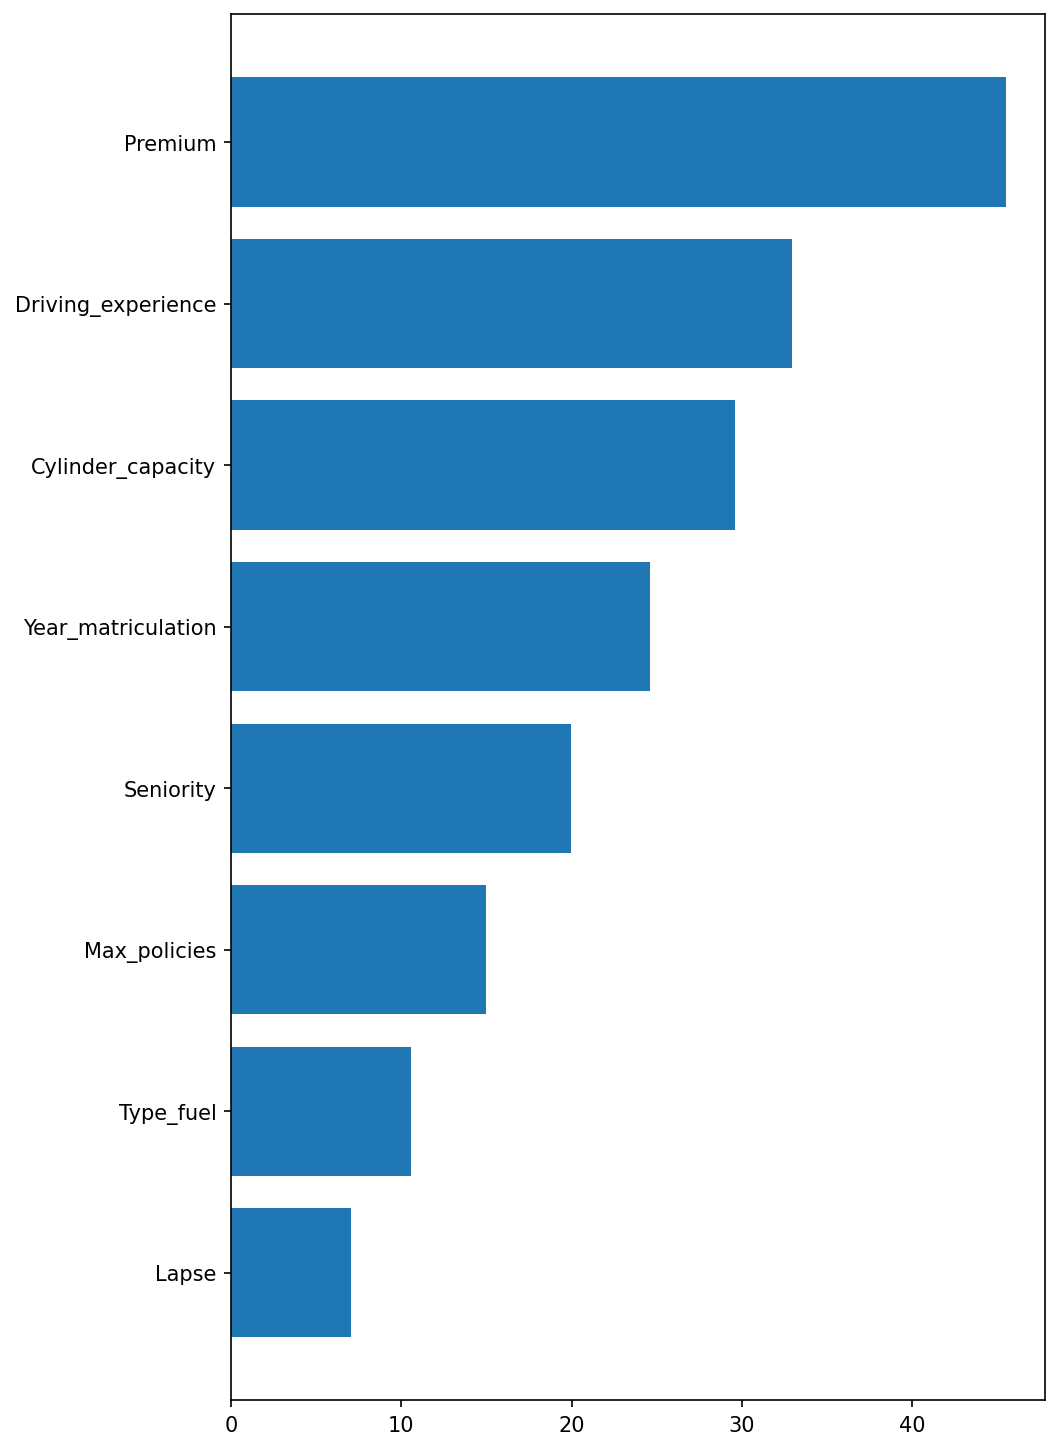

In [21]:
fig, ax = plt.subplots(dpi = 150, figsize = (7,12))
ax.barh(a['index'], a[0])

# Расчёт без дрифта

In [22]:
config_name = './configs/config-insurance-NoDrift.json'
path_to_data = './data/insurance.parquet'

In [23]:
with open(config_name, "r", encoding='utf-8') as f:
    model_config = f.read()
    model_config = AllModelsConfig.model_validate_json(model_config)

ds_manager = DataSetsManager(
    config_name=config_name,
    external_config=config)

df = ds_manager.load_dataset()

2025-09-15 12:36:36.030 | DEBUG    | outboxml.datasets_manager:_init_dsmanager:655 - Initializing DSManager
2025-09-15 12:36:36.031 | INFO     | outboxml.datasets_manager:__load_all_models_config:588 - All models config from path
2025-09-15 12:36:36.037 | INFO     | outboxml.datasets_manager:__load_all_models_config:606 - Config is loaded
2025-09-15 12:36:36.038 | INFO     | outboxml.datasets_manager:__load_prepare_datasets:625 - Load models prepare datasets
2025-09-15 12:36:36.038 | DEBUG    | outboxml.datasets_manager:_init_dsmanager:661 - Initializing completed
2025-09-15 12:36:36.039 | DEBUG    | outboxml.datasets_manager:load_dataset:289 - Dataset loading
2025-09-15 12:36:36.040 | INFO     | outboxml.extractors:load_dataset_from_local:129 - Load data from local file
2025-09-15 12:36:36.095 | DEBUG    | outboxml.extractors:load_dataset_from_local:154 - Data loaded successfully from /home/jovyan/work/examples/vehicle_insurance/data/insurance.parquet
2025-09-15 12:36:43.793 | DEBUG  

In [24]:
df[df['Date_start_contract'] > '2015-01-01'][df['Date_start_contract'] < '2018-01-01'].shape, df[df['Date_start_contract'] > '2018-01-01'].shape

((52658, 34), (11317, 34))

In [25]:
df_train = ds_manager.get_TrainDfs()

2025-09-15 12:36:43.826 | DEBUG    | outboxml.datasets_manager:_separateTestTrain:480 - Separation started
2025-09-15 12:36:43.833 | INFO     | outboxml.datasets_manager:_separateTestTrain:494 - X shape: (105555, 33), Y shape: (105555, 1)
2025-09-15 12:36:43.833 | INFO     | outboxml.datasets_manager:_separateTestTrain:495 - Y: ['TARGET']
2025-09-15 12:36:43.834 | INFO     | outboxml.core.prepared_datasets:train_test_indexes:153 - Date separation
2025-09-15 12:36:43.845 | INFO     | outboxml.core.prepared_datasets:train_test_indexes:166 - Train: 52693, test: 11343
2025-09-15 12:36:43.849 | DEBUG    | outboxml.datasets_manager:_separateTestTrain:526 - Separation finished
2025-09-15 12:36:43.850 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:43.851 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:43.852 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to par

In [26]:
df_test = ds_manager.get_TestDfs()

2025-09-15 12:36:44.303 | DEBUG    | outboxml.datasets_manager:get_TestDfs:331 - Model first || Test subset export
2025-09-15 12:36:44.304 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:44.305 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:44.306 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:44.308 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:44.344 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:44.375 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Policies_in_force || Исправлено значений вне интервала: 88
2025-09-15 12:36:44.389 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_products || Исправлено значений вне интервала: 40
2025-09-15 12:36:44.407 | INFO     

In [27]:
metrics_Nodrift = ds_manager.fit_models(need_fit=True)

2025-09-15 12:36:44.648 | DEBUG    | outboxml.datasets_manager:fit_models:353 - Fitting model started
2025-09-15 12:36:44.650 | INFO     | outboxml.datasets_manager:fit_models:361 - Setting default models
2025-09-15 12:36:44.652 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:44.653 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:44.655 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:44.722 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:44.770 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Policies_in_force || Исправлено значений вне интервала: 88
2025-09-15 12:36:44.784 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_products || Исправлено значений вне интервала: 40
2025-09-15 12:36:44.804 | INFO     | outboxml.core.dat

In [28]:
metrics_Nodrift

{'first': {'train': {'full': {'mae': 134.1441,
    'rmse': 518.4523,
    'r2': 0.8285}},
  'test': {'full': {'mae': 124.1093, 'rmse': 466.805, 'r2': -0.2214}}}}

In [29]:
ds_manager.check_datadrift('first')

2025-09-15 12:36:49.001 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:49.003 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:49.004 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:49.007 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:49.042 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:49.090 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Policies_in_force || Исправлено значений вне интервала: 88
2025-09-15 12:36:49.102 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_products || Исправлено значений вне интервала: 40
2025-09-15 12:36:49.119 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Power || Исправлено значений вне интервала: 87


,PSI,KL,JS
Max_products,0.000521,6.107954,0.356335
Driving_experience,0.057127,241.778711,8.138535
Type_fuel,0.000823,NaN,NaN
Length,0.017837,35.318699,1.472183
Power,0.080070,1058.760635,32.228232
Type_risk,0.002454,17.341729,0.919519
N_doors,0.004007,25.990728,1.383777
Policies_in_force,0.240184,8.421080,0.517162
Vehicle_age,0.134873,106.276421,4.030730


In [30]:
# Инициализация DataDrift с настройками
datadrift = DataDrift(
    full_calc=True,  # Включить полный расчет с дополнительными метриками
    columns_to_exclude=[],  # Столбцы для исключения из расчета
    n_bins=50,  # Количество бинов для численных признаков
    dif_len_string=100  # Максимальная длина строки для различий в категориальных признаках
)

In [31]:
# Расчет датадрифта
drift_report = datadrift.report(
    train_data=df_train[0],
    test_data=df_test[0],
    base_data=df_train[0],  # Базовые данные для полного расчета
    control_data=df_test[0]  # Контрольные данные для полного расчета
)

print("Отчет по датадрифту:")
display(drift_report.sort_values('PSI', ascending=False))
print("\nИнтерпретация метрик:")
print("- PSI (Population Stability Index): < 0.1 - стабильно, 0.1-0.2 - умеренный дрифт, > 0.2 - значительный дрифт")
print("- KL (Kullback-Leibler divergence): чем больше, тем больше различий в распределениях")
print("- JS (Jensen-Shannon divergence): нормализованная версия KL, от 0 до 1")


Отчет по датадрифту:


,PSI,KL,JS,TYPE,col,date,NaN_train,NaN_test,uniq_train,uniq_test,mode_train,mode_test,mean_train,mean_test,dif_train,dif_test
Policies_in_force,0.240184,8.42108,0.517162,NUMERICAL,Policies_in_force,2025-09-15,0.0,0.0,9,9,1.0,1.0,1.48923,1.886714,[],[]
Vehicle_age,0.108385,106.268136,4.027823,NUMERICAL,Vehicle_age,2025-09-15,0.0,0.0,58,57,12.0,13.0,11.610385,12.224015,[53.0],[]
Power,0.074259,1058.761102,32.227813,NUMERICAL,Power,2025-09-15,0.0,0.0,218,199,90.0,90.0,93.002945,95.449883,"[260.0, 264.0, 148.0, 277.0, 151.0, 152.0, 279...","[161.0, 265.0, 176.0, 273.0, 276.0, 213.0, 221.0]"
Driving_experience,0.051805,241.776427,8.137918,NUMERICAL,Driving_experience,2025-09-15,0.0,0.0,570,562,10.3,0.0,23.482559,22.772987,"[56.6, 56.8, 56.2, 56.4, 53.1, 55.5, 56.5, 56.1]",[]
Length,0.011711,35.315633,1.471465,NUMERICAL,Length,2025-09-15,0.0,0.0,957,854,4.188,4.188,4.254252,4.270678,"[2.95, 2.72, 2.933, 5.549, 6.538, 5.993, 6.269...","[2.995, 2.985, 2.79, 2.826, 6.545, 6.457, 4.75..."
N_doors,0.004007,25.990728,1.383777,NUMERICAL,N_doors,2025-09-15,0.0,0.0,6,6,5.0,5.0,4.056782,4.124835,[],[]
Type_risk,0.002454,17.341729,0.919519,NUMERICAL,Type_risk,2025-09-15,0.0,0.0,4,4,3.0,3.0,2.6944,2.719386,[],[]
Type_fuel,0.000823,NaN,NaN,NUMERICAL,Type_fuel,2025-09-15,0.0,0.0,3,3,6.391151,6.391151,-0.201175,0.044757,[],[]
Max_products,0.000521,6.107954,0.356335,NUMERICAL,Max_products,2025-09-15,0.0,0.0,3,3,1.0,1.0,1.056649,1.051486,[],[]



Интерпретация метрик:
- PSI (Population Stability Index): < 0.1 - стабильно, 0.1-0.2 - умеренный дрифт, > 0.2 - значительный дрифт
- KL (Kullback-Leibler divergence): чем больше, тем больше различий в распределениях
- JS (Jensen-Shannon divergence): нормализованная версия KL, от 0 до 1


In [32]:
results = ds_manager.get_result()

In [33]:
def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns
    
    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    if isinstance(shap_values, list):   # If shap values is a list of arrays (i.e., several classes)
        means = [np.abs(shap_values[class_][:, c_idxs]).mean(axis=0) for class_ in range(len(shap_values))]  # Compute mean shap values per class 
        shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes 
    else:                               # Else there is only one 2D array of shap values
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values).mean(axis=0)
    
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = pd.DataFrame({'feature': columns + ['C'], 'mean_shap_value': shap_means}).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

# ranking = shap_feature_ranking(X_v[4][model_cut.feature_names_], shap_values)
# ranking[ranking['feature'] != 'C']

In [34]:
model = results['first'].model.model
X_copy = ds_manager.get_TestDfs()[0]
target = ds_manager.get_TestDfs()[1]

shap_values = model.get_feature_importance(Pool(X_copy[model.feature_names_], target),
                                                            type=EFstrType.ShapValues)

ranking = shap_feature_ranking(X_copy[model.feature_names_], shap_values)
ranking = ranking[ranking['feature'] != 'C']
temp_dict = dict(zip(ranking['feature'], ranking['mean_shap_value']))
common_dict = {}
for key in temp_dict.keys():
    common_dict[key] = temp_dict[key]
a = pd.DataFrame.from_dict(common_dict, orient='index').reset_index().sort_values(0, ascending=True)

2025-09-15 12:36:50.058 | DEBUG    | outboxml.datasets_manager:get_TestDfs:331 - Model first || Test subset export
2025-09-15 12:36:50.058 | DEBUG    | outboxml.datasets_manager:get_subset:339 - Model first || Subset export
2025-09-15 12:36:50.060 | DEBUG    | outboxml.data_subsets:_prepare_subset:179 - Model first || Data preparation started
2025-09-15 12:36:50.061 | INFO     | outboxml.data_subsets:dataset:127 - Saving data to parquet
2025-09-15 12:36:50.063 | INFO     | outboxml.data_subsets:save_parquet:321 - ||Saving dataset to parquet
2025-09-15 12:36:50.103 | INFO     | outboxml.data_subsets:dataset:148 - Reading data from parquet
2025-09-15 12:36:50.135 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Policies_in_force || Исправлено значений вне интервала: 88
2025-09-15 12:36:50.148 | INFO     | outboxml.core.data_prepare:prepare_numerical_feature_series:490 - Max_products || Исправлено значений вне интервала: 40
2025-09-15 12:36:50.166 | INFO     

<BarContainer object of 9 artists>

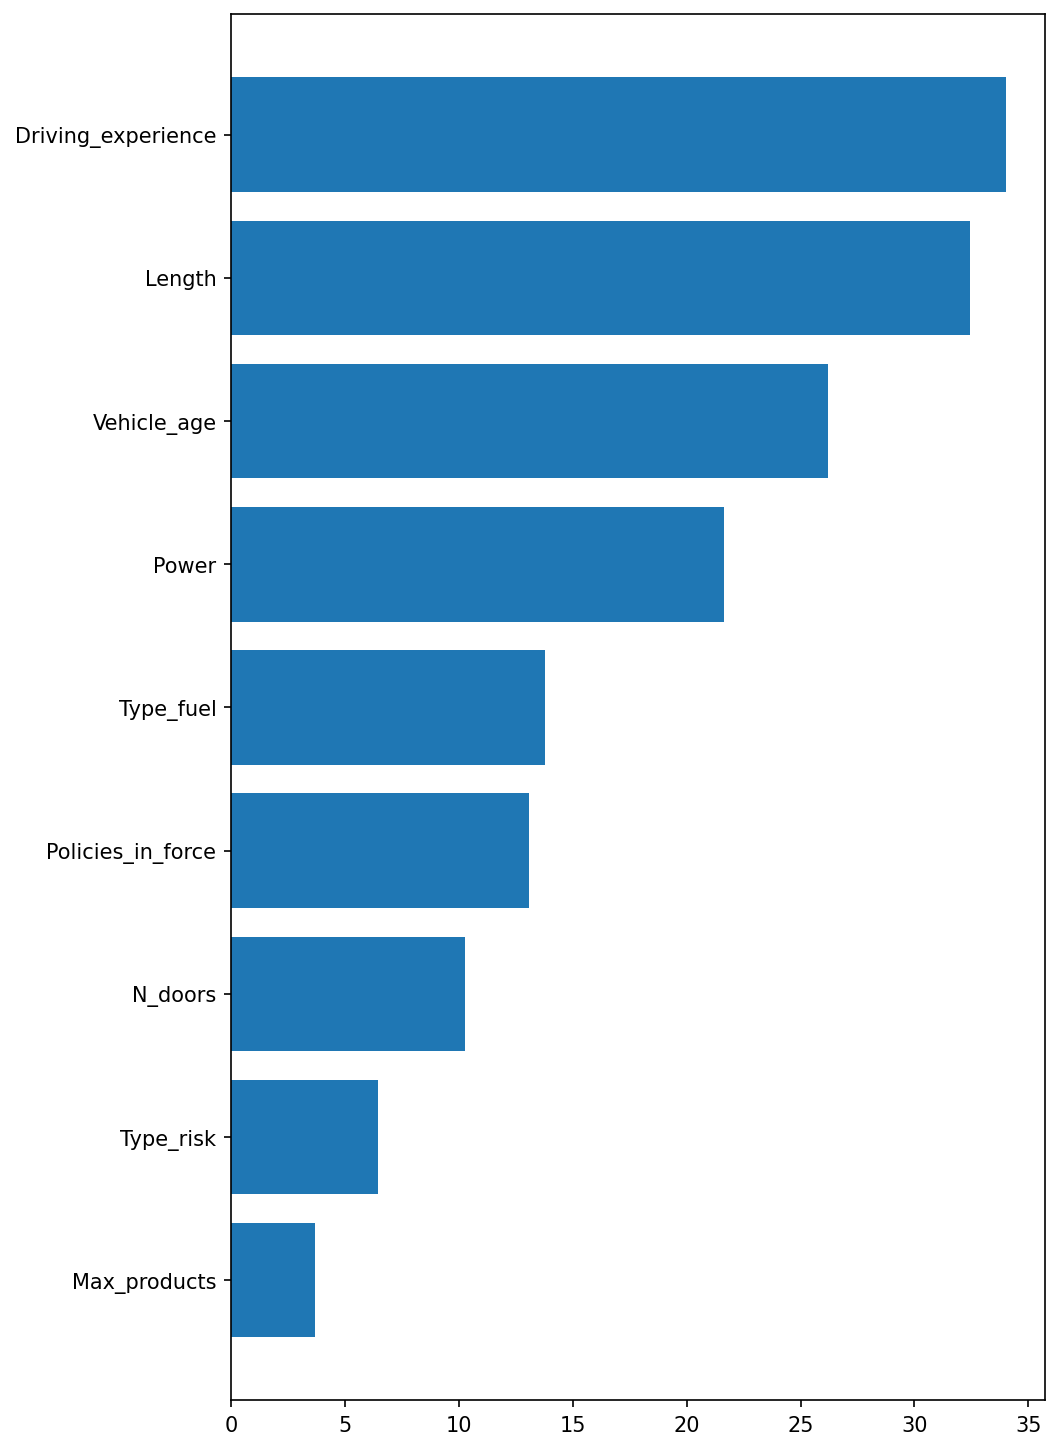

In [35]:
fig, ax = plt.subplots(dpi = 150, figsize = (7,12))
ax.barh(a['index'], a[0])

# Вывод

In [36]:
print('Метрики на обучении')
display( pd.concat([pd.DataFrame(metrics_drift['first']['train']).rename({'full':'Drift'}, axis=1),
           pd.DataFrame(metrics_Nodrift['first']['train']).rename({'full':'NoDrift'}, axis=1)], axis=1) )

print('Метрики на применении')
display( pd.concat([pd.DataFrame(metrics_drift['first']['test']).rename({'full':'Drift'}, axis=1),
           pd.DataFrame(metrics_Nodrift['first']['test']).rename({'full':'NoDrift'}, axis=1)], axis=1) )


Метрики на обучении


,Drift,NoDrift
mae,137.2876,134.1441
rmse,533.1806,518.4523
r2,0.8187,0.8285


Метрики на применении


,Drift,NoDrift
mae,136.2526,124.1093
rmse,794.9494,466.8050
r2,-2.5421,-0.2214
